## 🐶 Kaggle End-to-End Multiclass Dog Breed Classification using Transfer Learning 🐶
### Kaggle Dog Breed Identification: Determine the breed of a dog in an image 
Our goal is to answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of good pup is that?

## Dataset Description
You are provided with a [training set and a test set of images of dogs](https://www.kaggle.com/c/dog-breed-identification/data). Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to **create a classifier capable of determining a dog's breed from a photo**. 

In this playground competition, you are provided a strictly canine subset of `ImageNet` in order to practice fine-grained image categorization. With `120` breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

### File descriptions
* `train.zip` - the training set, you are provided the breed for these dogs
* `test.zip` - the test set, you must predict the probability of each breed for each image
* `sample_submission.csv` - a sample submission file in the correct format
* `labels.csv` - the breeds for the images in the train set

### Acknowledgments
We extend our gratitude to the creators of the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) for making this competition possible: Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao, and Fei-Fei Li.

### Evaluation
Submissions are evaluated on [Multi Class Log Loss](https://www.kaggle.com/wiki/MultiClassLogLoss) between the predicted probability and the observed target.

### Import needed packages
**Note**: GPU support on native-Windows is only available for **tensorflow version 2.10** or earlier. You will have to install tensorflow as follows: `pip install tensorflow==2.10.0`. You may have to uninstall any later version before installing version 2.10.

Install GPU plugin `pip install tensorflow-directml-plugin`

`conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0`

`pip install numpy==1.21.5` for ananconda 2022.05

#### Import resource
https://github.com/tensorflow/docs/tree/master/site/en/hub/tutorials

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_hub as hub
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
import datetime

print(f'TF version: {tf.__version__}')
print(f'TF-Hub version: {hub.__version__}')

TF version: 2.10.0
TF-Hub version: 0.16.1


#### `TensorFlow` and `PyTorch` methods directly check if a compatible GPU is available for deep learning tasks.
* For TensorFlow, you can check the available **GPUs** with:

In [2]:
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

GPU is available


In [3]:
print('GPU is', 'available' if torch.cuda.is_available() else 'NOT AVAILABLE')

GPU is available


#### `GPUtil` provides more detailed information about all GPUs available on your system, including their IDs and names, which is helpful in multi-GPU systems.

In [4]:
import GPUtil

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

if gpus:
    print('GPU(s) are available:')
    for gpu in gpus:
        print(f'GPU {gpu.id}: {gpu.name}')
else:
    print('No GPU is available')

GPU(s) are available:
GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU


## Getting the Data ready
### Load Data Labels

In [5]:
labels_csv = pd.read_csv('./data/labels.csv')
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


### How many image are there of each breed?

In [7]:
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

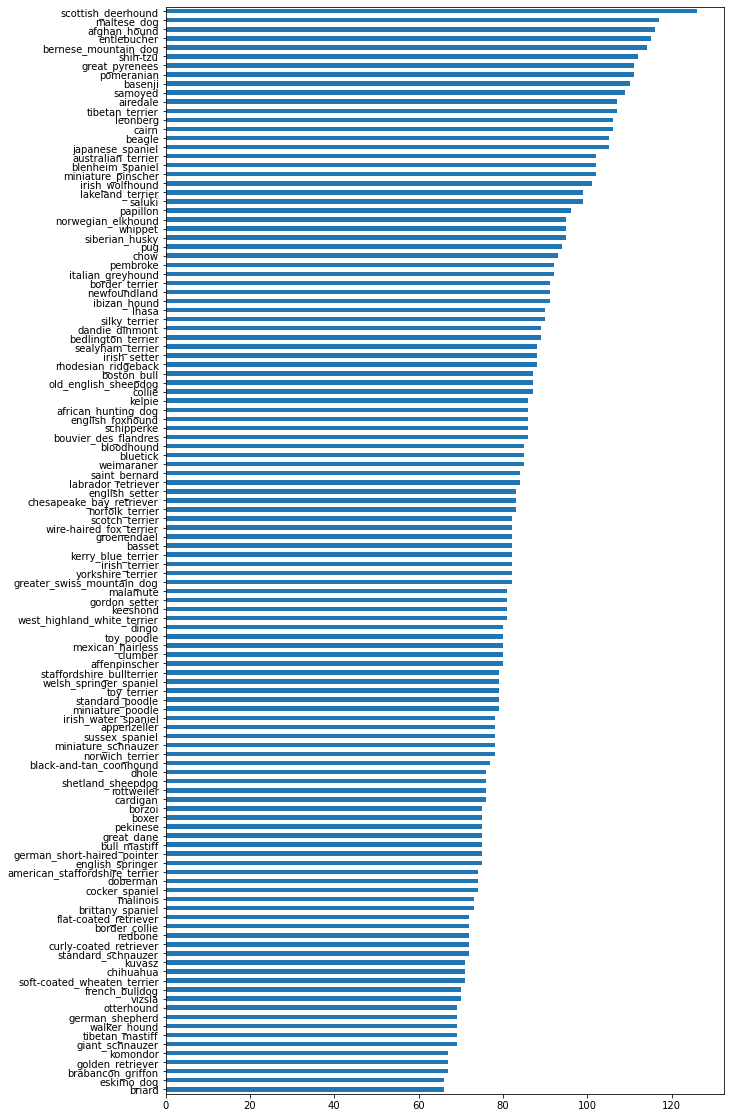

In [8]:
labels_csv['breed'].value_counts().sort_values().plot.barh(figsize = (10, 20));

### How many images are there per class?

In [9]:
labels_csv['breed'].value_counts().sort_values().describe()

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
Name: breed, dtype: float64

On average, there are `85` images per class and there are `120` different classes of dog breeds.
### Visualize sample images

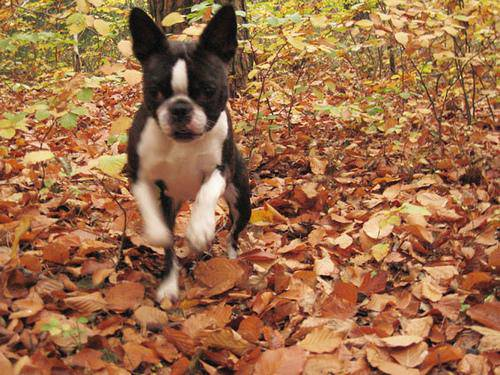

In [10]:
Image('./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

### Get a list of all images pathnames

In [11]:
filenames = ['./data/train/' + fname + '.jpg' for fname in labels_csv['id']]
filenames[:10]

['./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 './data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 './data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Check whether number of filenames matches number of actual image files

In [12]:
import os

if len(os.listdir('./data/train/')) == len(filenames):
    print('Filenames match actual amount of files!')
else:
    print('Filenames do not match actual amount of files! Check target directory')

Filenames match actual amount of files!


### Getting the labels ready

In [13]:
labels = labels_csv['breed'].to_numpy()
print(len(labels))
labels

10222


array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
if len(os.listdir('./data/train/')) == len(labels):
    print('Filenames match actual amount of labels!')
else:
    print('Filenames do not match actual amount of labels! Check target directory')

Filenames match actual amount of labels!


### Unique Labels

In [15]:
unique_breeds = np.unique(labels)
print(len(unique_breeds))
print(unique_breeds)

120
['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'ita

### Turning every label into a boolean array

In [16]:
boolean_labels = [label == unique_breeds for label in labels]
print(len(boolean_labels))
print(boolean_labels[0])

10222
[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


### Turning boolean array into integers

In [17]:
integer_labels = [list(map(int, bool_list)) for bool_list in boolean_labels]
print(len(integer_labels))
print(integer_labels[:2])

10222
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [18]:
X = filenames
y = integer_labels

### Converting images into tensors
We are going to define a helper function for this preprocessing step. We make use of Tensorflow's [Load and preprocess images ](https://www.tensorflow.org/tutorials/load_data/images) tutorials.

In [19]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

def process_image(image_path):
    '''Takes an image path and converts the image into a tensor'''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels = 3)        # convert to tensor
    image = tf.image.convert_image_dtype(image, tf.float32)  # from (0 - 255) to (0 - 1)
    image = tf.image.resize(image, size = (IMG_WIDTH, IMG_HEIGHT))
    return image

In [20]:
image_0 = process_image(filenames[0])
print(image_0)

tf.Tensor(
[[[0.5705322  0.33588538 0.15008473]
  [0.66901225 0.4601166  0.26022965]
  [0.6106238  0.43763596 0.21601711]
  ...
  [0.8182312  0.7297958  0.26963907]
  [0.72454786 0.6059109  0.2653059 ]
  [0.7494603  0.6252919  0.32456532]]

 [[0.6761415  0.4733761  0.3064293 ]
  [0.5672121  0.38192675 0.20349538]
  [0.58835477 0.43225706 0.24031551]
  ...
  [0.9326942  0.8260503  0.41093278]
  [0.8607247  0.74250627 0.36941224]
  [0.7678166  0.6461604  0.29291284]]

 [[0.46350825 0.29595745 0.1536156 ]
  [0.4255411  0.270394   0.12009468]
  [0.7887874  0.6547362  0.49015   ]
  ...
  [0.89372385 0.7696401  0.41811958]
  [0.8860953  0.7585917  0.36495727]
  [0.8243601  0.69494826 0.2930575 ]]

 ...

 [[0.7344025  0.4716574  0.2559711 ]
  [0.7137255  0.45882356 0.24705884]
  [0.73858845 0.48431677 0.27286717]
  ...
  [0.70885915 0.5011093  0.3242799 ]
  [0.8884395  0.6805963  0.4820492 ]
  [0.8582441  0.65040094 0.4518538 ]]

 [[0.7300675  0.46732238 0.2516361 ]
  [0.7170148  0.46211284 0

### Turning data into batches
It would be appropriate for our data to be in the form `(image, label)` tensor to effectively use tensorflow. Let's define a helper function for this step.

In [21]:
def get_image_label(image_path, label):
    """
    input arguments: image path, image label
    return: tensor(image, label)
    """
    image = process_image(image_path)
    return image, label

In [22]:
image_0 = get_image_label(filenames[0], tf.constant(integer_labels[0]))
print(image_0)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.5705322 , 0.33588538, 0.15008473],
        [0.66901225, 0.4601166 , 0.26022965],
        [0.6106238 , 0.43763596, 0.21601711],
        ...,
        [0.8182312 , 0.7297958 , 0.26963907],
        [0.72454786, 0.6059109 , 0.2653059 ],
        [0.7494603 , 0.6252919 , 0.32456532]],

       [[0.6761415 , 0.4733761 , 0.3064293 ],
        [0.5672121 , 0.38192675, 0.20349538],
        [0.58835477, 0.43225706, 0.24031551],
        ...,
        [0.9326942 , 0.8260503 , 0.41093278],
        [0.8607247 , 0.74250627, 0.36941224],
        [0.7678166 , 0.6461604 , 0.29291284]],

       [[0.46350825, 0.29595745, 0.1536156 ],
        [0.4255411 , 0.270394  , 0.12009468],
        [0.7887874 , 0.6547362 , 0.49015   ],
        ...,
        [0.89372385, 0.7696401 , 0.41811958],
        [0.8860953 , 0.7585917 , 0.36495727],
        [0.8243601 , 0.69494826, 0.2930575 ]],

       ...,

       [[0.7344025 , 0.4716574 , 0.2559711 ],
        [0.7

**Let's make a helper function to convert all the images and labels into `Tensor(image, label)` in batches**

In [23]:
BATCH_SIZE = 32
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    """
    X = filenames
    y = integer_labels
    Creates batches of image (data (X), label (y)) pairs
    NOTE: when test_data = True, y = None (test data has not labels)
    """
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    # If validation data, no shuffling
    elif valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))  
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        print('Creating training data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) 
        data = data.shuffle(buffer_size = len(X))  # shuffling before mapping is faster
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

In [24]:
full_data = create_data_batches(X, y)

Creating training data batches...


### Check out the different attributes of our training data batches

In [25]:
full_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.int32, name=None))

## Building the model
Instead of building a model from scatch, we are going to use `transfer learning` approach. This is using a pretrained model as our starting model, then update or fine tuned its weights or parameters using our training dataset.

`https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2`

In [26]:
INPUT_SHAPE = (None, IMG_WIDTH, IMG_HEIGHT, 3)
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = 'https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2'

### Build the model
#### MobileNet V2 Architecture

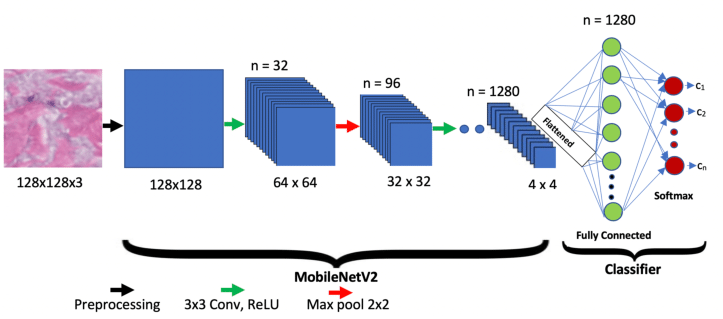

We are going to use a helper function to define and compile our model.

Note that we decided that our image size should be `124 x 124` but we could as well use `128 x 128` or any other dimension as deemed necessary. 

In [27]:
def create_model(input_shape = INPUT_SHAPE,
                 output_shape = OUTPUT_SHAPE,
                 model_url = MODEL_URL,
                ):
    print(f'Building model with: {MODEL_URL}')
    
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),
        tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                              activation = 'softmax'
                             )
        
    ])
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy']
    )
    model.build(INPUT_SHAPE)
    return model

In [28]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


We get `5,432,713` parameters already trained by using transfer learning or a pretrained model. Our model will train just `120,240` parameters. This should make it faster compared to if it were to train `5 million+` parameters!

### Creating some helper callback functions
#### Tensorboard callback
* We need a tensorboard notebook extension ✅
* Create a tensorboard callback to save logs to a directory ✅
* Visualize our model's training logs with `%tensorboard` magic function ✅

In [29]:
%load_ext tensorboard

In [30]:
def create_tensorboard_callback():
    logdir = os.path.join('./logs', 
                         datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

#### Early Stopping callback: Preventing Overfitting
An early stopping callback stops the training when the metrics is no longer improving. This helps to prevent `overfitting`, that is, it prevents the model from learning patterns that are not part of the distribution from which the data was generated. Early stopping prevent the model from learning noise which cannot generalize to test data or data not previously seen by the model.

**NOTE**: When training with full dataset, there is no valudation set. This means we can't monitor validation accuracy. We will monitor `accuracy` when training with full dataset.

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 3)

## Training the model (on a full data)

### Define a helper function to train a model

In [32]:
NUM_EPOCHS = 100

def train_model():
    '''Train and return a model'''
    model = create_model()
    tensorboard = create_tensorboard_callback()
    model.fit(x = full_data,
              epochs = NUM_EPOCHS,
              callbacks = [tensorboard, early_stopping])
    return model

### Train on GPU
**`TensorFlow` and `PyTorch` methods directly check if a compatible GPU is available for deep learning tasks.** But we can ensure that available GPU is utilized.

In [33]:
with tf.device('/GPU:0'):
    start = timer()
    model = train_model()
    end = timer()

total = end - start
print(f'\nGPU time: {total}')

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Epoch 1/100
320/320 [==============================] - 23s 66ms/step - loss: 1.3306 - accuracy: 0.6723
Epoch 2/100
320/320 [==============================] - 22s 69ms/step - loss: 0.4025 - accuracy: 0.8827
Epoch 3/100
320/320 [==============================] - 22s 69ms/step - loss: 0.2348 - accuracy: 0.9372
Epoch 4/100
320/320 [==============================] - 22s 69ms/step - loss: 0.1555 - accuracy: 0.9625
Epoch 5/100
320/320 [==============================] - 22s 69ms/step - loss: 0.1056 - accuracy: 0.9777
Epoch 6/100
320/320 [==============================] - 22s 70ms/step - loss: 0.0794 - accuracy: 0.9854
Epoch 7/100
320/320 [==============================] - 22s 70ms/step - loss: 0.0573 - accuracy: 0.9925
Epoch 8/100
320/320 [==============================] - 22s 70ms/step - loss: 0.0461 - accuracy: 0.9946
Epoch 9/100
320/320 [==============================] - 22s 69ms/step

In [34]:
total_time = total / 60
print(f'Total GPU time: {total_time: .2f} mins')

Total GPU time:  7.57 mins


This training time with GPU is insane!!! Even the first epoch took just 23 secs because my system has sufficient memory! 

As we can see, the training stopped after completing just 16 epochs. This is because the training accuracy stopped improving after 3 epochs, as we indicated when the early stopping callback was defined. 

#### Observations
The training accuracy reached `100%`. We did provide any validation set. We should be concerned about possible `overfitting`! The model is performing too well on the training data.

Other approaches to overcomming overfitting would be to use more training data or using `dropout` layers and `weights regularization`.

## Saving and Loading a Trained Model

In [35]:
def save_model(model, suffix = None):
    modeldir = os.path.join('./saved_model', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    model_path = f'{modeldir}_{suffix}.h5'
    print(f'Saving model to: {model_path}...')
    model.save(model_path)
    return model_path

def load_model(model_path):
    print(f'Loading saved model from: {model_path}...')
    model = tf.keras.models.load_model(model_path, custom_objects = {'KerasLayer': hub.KerasLayer})
    return model

### Use the helper functions to save and load model

In [36]:
model_path = save_model(model, suffix = 'full-image-set-mobilenetv2-Adam')

Saving model to: ./saved_model\20250115-112502_full-image-set-mobilenetv2-Adam.h5...


In [37]:
loaded_full_image_model = load_model(model_path)

Loading saved model from: ./saved_model\20250115-112502_full-image-set-mobilenetv2-Adam.h5...


## Loading and preprocessing the test dataset for prediction
We'll have to get the test data into tensors as we did with the training data.

In [38]:
test_path = './data/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
print(len(test_filenames))
test_filenames[:10]

10357


['./data/test/000621fb3cbb32d8935728e48679680e.jpg',
 './data/test/00102ee9d8eb90812350685311fe5890.jpg',
 './data/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 './data/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 './data/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 './data/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 './data/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 './data/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 './data/test/002f80396f1e3db687c5932d7978b196.jpg',
 './data/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

### Convert the files or images into data batche  using `create_data_batches` function

In [39]:
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [40]:
test_data.element_spec

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)

As expected, the test data has not got labels.
## Make Predictions using the loaded model

In [41]:
with tf.device('/GPU:0'):
    start = timer()
    test_prediction = loaded_full_image_model.predict(test_data, verbose = 1)
    end = timer()

total = end - start
print(f'\nGPU time: {total: .4f}')

324/324 [==============================] - 20s 59ms/step

GPU time:  19.6537


It has taken less than a minute to make predictions on more than `10k` images using GPU on my device! This would take more than an hour on colab!

### Saving the predictions as `csv` file for possible submission to Kaggle

In [42]:
np.savetxt('./data/predictions/preds_array.csv', test_prediction, delimiter = ',')

### Load predictions

In [43]:
test_predictions = np.loadtxt('./data/predictions/preds_array.csv', delimiter = ',')
test_predictions[:10]

array([[2.00307670e-11, 3.86308173e-12, 1.32734035e-14, ...,
        1.10109899e-13, 1.23425581e-09, 1.26226349e-10],
       [1.81869859e-06, 1.79593030e-06, 1.37752201e-08, ...,
        1.88552715e-11, 2.91158440e-08, 1.14475507e-09],
       [4.97588732e-12, 8.83682887e-08, 7.67545971e-10, ...,
        1.00053462e-07, 2.88157280e-12, 3.17481545e-12],
       ...,
       [5.69014613e-09, 2.49475524e-10, 2.30704501e-11, ...,
        2.63902745e-12, 7.35942015e-13, 7.71477118e-11],
       [6.72183229e-12, 2.14059201e-10, 5.41555030e-11, ...,
        3.67005981e-07, 3.41207573e-09, 8.54951873e-12],
       [8.12725887e-10, 1.69739431e-11, 7.27394794e-12, ...,
        8.58519934e-14, 3.06238867e-12, 8.89021692e-08]])

In [44]:
print(test_predictions.shape)

(10357, 120)


### Prepare a Kaggle Submision
The [submission file](www.kaggle.com/competitions/dog-breed-identification/overview/evaluation) expects a csv file with the image IDs being the first column, followed by the names of the dog classes. The data for the class names are the prediction probabilities for each image id. ***"For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:"***

    id, affenpinscher, afghan_hound, .., yorkshire_terrier
    000621fb3cbb32d8935728e48679680e, 0.0083, 0.0, ..., 0.0083
    etc.
    
#### We'll use to following approach o extract the test `ids`

In [45]:
'./data/test/000621fb3cbb32d8935728e48679680e.jpg'.split('/')[-1][:-4]

'000621fb3cbb32d8935728e48679680e'

In [46]:
test_ids = [fname.split('/')[-1][:-4] for fname in test_filenames]

In [47]:
preds_df = pd.DataFrame(columns = ['id'] + list(unique_breeds))
preds_df['id'] = test_ids
preds_df[list(unique_breeds)] = test_predictions
print(preds_df.shape)
preds_df.head()

(10357, 121)


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.003077e-11,3.863082e-12,1.327340e-14,7.156338e-14,5.246901e-13,1.273880e-11,5.985193e-16,2.551144e-13,3.015978e-13,...,1.672909e-12,6.311560e-14,4.572506e-14,2.442564e-15,4.435876e-14,5.003992e-13,1.919279e-13,1.101099e-13,1.234256e-09,1.262263e-10
1,00102ee9d8eb90812350685311fe5890,1.818699e-06,1.795930e-06,1.377522e-08,2.081165e-09,6.030623e-07,3.888739e-09,1.927479e-06,2.055494e-07,1.323097e-08,...,9.577597e-09,3.043777e-07,1.118308e-09,4.442589e-06,4.497073e-08,5.284723e-08,2.135935e-04,1.885527e-11,2.911584e-08,1.144755e-09
2,0012a730dfa437f5f3613fb75efcd4ce,4.975887e-12,8.836829e-08,7.675460e-10,3.077890e-12,1.816166e-11,1.421228e-08,1.788954e-12,4.463075e-13,2.332762e-10,...,3.736226e-12,5.653568e-12,2.979788e-09,5.659759e-07,1.253017e-08,6.487262e-09,3.253007e-13,1.000535e-07,2.881573e-12,3.174815e-12
3,001510bc8570bbeee98c8d80c8a95ec1,2.838017e-07,1.517103e-07,1.714725e-07,5.870908e-07,1.402917e-05,3.368464e-07,2.935753e-11,5.148579e-09,7.769867e-09,...,4.591967e-06,1.660085e-10,7.077738e-08,1.702845e-09,3.702032e-07,8.453409e-11,7.374438e-16,5.607392e-02,1.359325e-11,2.756201e-07
4,001a5f3114548acdefa3d4da05474c2e,4.061247e-05,1.259576e-06,9.600009e-09,1.053915e-10,4.265614e-10,3.770431e-12,3.572954e-11,2.321806e-09,2.689128e-09,...,2.143728e-08,7.501604e-12,3.174296e-11,1.879663e-11,7.607844e-11,1.228194e-10,4.955490e-12,2.021812e-09,1.468085e-10,8.105134e-09


### Save the DataFrame as `csv` for submission

In [48]:
preds_df.to_csv('./data/submission/kaggle_dog_preds_submission_mobilenetV2_1.csv', index = False)

## Making Predictions on Custom Images using our Trained Model
To use our model to predict a dog's breed, we'll first have to transform the image into a batch, similar to the images which were used to train the model. I have downloaded some images and save them in a file called `custom_images`.

### Helper function to convert images to `JPEG` or expected format
Custom images might not be in the expected format. If you encounter error such as `Unknown image file format. One of JPEG, PNG, GIF, BMP required`, try converting the images to one of `JPEG, PNG, GIF, BMP`.

In [49]:
from PIL import Image

def convert_to_jpeg(image_path, output_path):
    with Image.open(image_path) as img:
        img.convert('RGB').save(output_path, 'JPEG')

In [50]:
custom_image_path = './data/custom_images/'
custom_filenames = [custom_image_path + fname for fname in os.listdir(custom_image_path)]
custom_filenames

['./data/custom_images/dog1.jpeg',
 './data/custom_images/dog2.jpeg',
 './data/custom_images/dog3.jpeg',
 './data/custom_images/dog4.jpeg',
 './data/custom_images/dog5.jpeg']

In [51]:
for file in custom_filenames:
    convert_to_jpeg(file, file)

### Turn custom images into batches
Since the custom images have no labels, we set `test_data = True`

In [52]:
custom_data = create_data_batches(custom_filenames, test_data = True)

Creating test data batches...


In [53]:
custom_data.element_spec

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)

### Make predictions

In [54]:
custom_preds = loaded_full_image_model.predict(custom_data)
custom_preds[0]

1/1 [==============================] - 0s 304ms/step


array([8.41791636e-11, 1.99532765e-10, 4.61703349e-11, 6.17066007e-08,
       1.36105252e-08, 5.85909585e-11, 2.16846785e-09, 1.67286646e-06,
       3.85668301e-07, 4.15898057e-06, 1.24360888e-09, 8.47147398e-14,
       4.64986671e-09, 1.73760450e-09, 4.68995381e-07, 2.84369790e-08,
       1.12863374e-09, 7.53628839e-08, 6.74196809e-11, 2.69507999e-10,
       2.22591376e-10, 7.26203586e-09, 2.90776914e-09, 3.77184284e-10,
       1.24242074e-08, 1.46625005e-08, 8.70266879e-12, 3.39185242e-11,
       5.42589396e-09, 1.36247486e-10, 1.11901919e-07, 3.70678661e-12,
       7.56519902e-10, 8.62035776e-09, 1.79600459e-08, 4.25820623e-09,
       1.94057392e-08, 6.92454378e-08, 4.56845184e-09, 9.98262346e-01,
       4.80624873e-10, 4.23672764e-10, 2.87185675e-09, 4.26822204e-08,
       2.39315612e-09, 1.28635790e-07, 1.97712708e-08, 3.82697563e-09,
       7.11368325e-11, 9.34180576e-13, 4.74734752e-10, 4.39832668e-08,
       1.31210709e-10, 1.39217287e-08, 5.35256561e-11, 6.45350156e-08,
      

## Transforming Predictions to corresponding text Labels
We'll define a helper function for this task.

In [55]:
def get_prediction_labels(predictions):
    '''Convert an array of probabilities into labels'''
    
    return np.array([unique_breeds[np.argmax(pred_probs)] for pred_probs in predictions])

In [56]:
custom_pred_labels = get_prediction_labels(custom_preds)
list(custom_pred_labels)

['english_foxhound',
 'weimaraner',
 'labrador_retriever',
 'rottweiler',
 'staffordshire_bullterrier']

### Unbatch Custom Data
Our previously define `unbatch`  function won't work since our custom images don't have labels. We'll use Numpy iterator instead.

In [57]:
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

### Visualize Custom Predictions

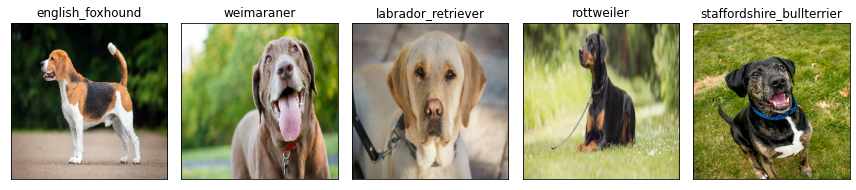

In [58]:
plt.figure(figsize = (12, 4))
for i, image in enumerate(custom_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
plt.tight_layout();

### Evaluating Model Performance with Tensorboard
The tensorboard magic function `%tensorboard` will access the log directory we created earlier and visualize its content.

NOTE: If there are several log files in the directory, you can uncheck corresponding check boxes if you don't wish to see the evaluation.

In [59]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 24192), started 1 day, 23:48:39 ago. (Use '!kill 24192' to kill it.)